In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from vocab import Vocabulary
from env2 import ConceptData
from create_data import addFile
import tensorflow as tf
import random
import numpy as np
import csv
import re
import os
import create_data
from xml.dom import minidom
import xml.etree.ElementTree as ET
import agents
import sender2
import game2
from agents import find_lengths

In [2]:
NUM_OPTIONS = 10
NUM_DISTRACTORS = 9
BATCH_SIZE = 32
HIDDEN_SIZE = 50
EMBED_DIM = 50
VOCAB_SIZE = 99
MAX_LEN = 10
NUM_EPOCHS = 2000
TRAINING = True
SENDER_ALL_INPUT = True
sender_entropy_coeff = 0.015 #wie bei Ossenkopf
receiver_entropy_coeff = 0.0 # wie bei Ossenkopf


In [3]:

vocabulary = Vocabulary()

def addFile(name):
    file_name = name + "_structured_final.xml"
    file = minidom.parse(os.path.join(os.path.join('visa_dataset', 'UK'), file_name))
    concepts = file.getElementsByTagName('concept')

    for concept in concepts:
        vocabulary.addConcept(concept)


addFile("ANIMALS")
addFile("APPLIANCES")
addFile("ARTEFACTS")
addFile("CLOTHING")
addFile("CONTAINER")
addFile("DEVICE")
addFile("FOOD")
addFile("HOME")
addFile("INSTRUMENTS")
addFile("MATERIAL")
addFile("PLANTS")
addFile("STRUCTURES")
addFile("TOOLS")
addFile("TOYS")
addFile("VEHICLES")
addFile("WEAPONS")

for concept in vocabulary.concept_list:
    vocabulary.parseConcept(concept)

In [4]:
#Initialisiere die Agents
sender_encoder = sender2.Sender(hidden_size=EMBED_DIM, num_options=NUM_OPTIONS, batch_size=BATCH_SIZE)
sender_LSTM = sender2.Sender_LSTM(agent = sender_encoder,
                                    embed_dim=EMBED_DIM,
                                    num_cells=1,
                                    hidden_size=1, 
                                    max_len=MAX_LEN,
                                see_all_input=SENDER_ALL_INPUT)
receiver_encoder = agents.Receiver(hidden_size=EMBED_DIM, num_options = NUM_OPTIONS)
receiver_LSTM = agents.Receiver_LSTM(agent=receiver_encoder, 
                                       vocab_size=VOCAB_SIZE,
                                       embed_dim=EMBED_DIM, 
                                       hidden_size=HIDDEN_SIZE)
guesser = agents.AuxiliaryNetwork(hidden_size=HIDDEN_SIZE)


In [5]:
#the losses

#loss of guessing the correct target
def loss(_sender_input, _message, _receiver_input, input_concepts, receiver_output, targets):
    """
    receiver_output ist was von receiver_sampling zurückgegeben wird
    LABELS PRINTEN IN OSSSENKOPF NOTEBOOK
    """
    guesses = []
    
    for i in range(len(receiver_output)):
        guesses.append(input_concepts[i][receiver_output[i]])
            
    guesses = tf.convert_to_tensor(guesses)
    targets = tf.convert_to_tensor(targets)
    acc = np.sum(guesses == targets) - np.sum(guesses != targets)
        
    return -acc

#auxiliary loss to promote empathy
def auxiliary_loss(receiver_thoughts, 
                  # _message, _receiver_input, 
                   guesser_output, 
                   #_labels,
                   weight=0.2):
    mae = tf.keras.losses.MeanAbsoluteError(reduction = 'none')
    loss = mae(receiver_thoughts, guesser_output)
    loss *= weight
    
    return loss

In [6]:
game = game2.Game(sender_encoder=sender_encoder,
                  sender=sender_LSTM,
                receiver=receiver_LSTM,
                main_loss=loss,
                sender_entr_coeff=sender_entropy_coeff,
                receiver_entr_coeff=receiver_entropy_coeff,
                batch_size=BATCH_SIZE,
                max_len=MAX_LEN,
                 sender_all_input=SENDER_ALL_INPUT)

In [7]:
optim_guesser = tf.keras.optimizers.Adam(learning_rate = 1e-3)
optim_receiver = tf.keras.optimizers.Adam(learning_rate = 1e-2)
optim_sender = tf.keras.optimizers.Adam(learning_rate = 1e-3)
#optim_game = tf.keras.optimizers.Adam(learning_rate = 1e-5)

In [8]:
losses_network = []
losses_aux = []
accuracy = []
main_loss = []
train_steps = []

for i in range(NUM_EPOCHS):
    
    data = ConceptData(voc=vocabulary, num_distractors=NUM_DISTRACTORS, batch_size=BATCH_SIZE)
    input_concepts, sender_input, targets, receiver_input = data.getInput()
    
    
    with tf.GradientTape(persistent=True) as tape:
        
        loss, prev_hidden, last_hidden, acc, message = game(input_concepts, sender_input, targets, receiver_input)
        losses_network.append(np.mean(loss))
        receiver_gradients = tape.gradient(loss, game.receiver.trainable_variables)
        sender_lstm_gradients = tape.gradient(loss, game.sender.trainable_variables)
        sender_encoder_gradients = tape.gradient(loss, game.sender_encoder.trainable_variables)

    optim_receiver.apply_gradients((grad, var) for (grad, var) in zip(receiver_gradients, game.receiver.trainable_variables) if grad is not None)
    optim_sender.apply_gradients((grad, var) for (grad, var) in zip(sender_lstm_gradients, game.sender.trainable_variables) if grad is not None)
    
    with tf.GradientTape() as tape:
        
        guesser_output = guesser(prev_hidden)
        aux_loss = auxiliary_loss(last_hidden, guesser_output)
        aux_loss_mean = np.mean(aux_loss)
        
        if i % 25 == 0:
            train_steps.append(i)
            losses_aux.append(aux_loss_mean)
            main_loss.append(np.mean(loss))
            accuracy.append(np.mean(acc))
        
        aux_gradients = tape.gradient(aux_loss, guesser.trainable_variables)
        
        # add gradients of guesser onto gradients of sender_encoder to update sender_encoder with these
        #sender_encoder_grad_all = []
        #for i in range(len(aux_gradients)):
            #sender_encoder_grad_all.append(aux_gradients[i] + sender_encoder_gradients[i])
        
    optim_guesser.apply_gradients(zip(aux_gradients, guesser.trainable_variables))
    #optim_sender.apply_gradients(zip(sender_encoder_grad_all, game.sender_encoder.trainable_variables))
    print(f'epoch::: {i}   loss::: {np.mean(loss)}   acc::: {acc}   aux_loss::: {aux_loss_mean}')
        

epoch::: 0   loss::: -396.57513427734375   acc::: -26.0   aux_loss::: 0.0990968570113182
epoch::: 1   loss::: -425.44586181640625   acc::: -28.0   aux_loss::: 0.09997430443763733
epoch::: 2   loss::: -304.3157958984375   acc::: -24.0   aux_loss::: 0.10114388167858124
epoch::: 3   loss::: -457.9580078125   acc::: -30.0   aux_loss::: 0.1032290831208229
epoch::: 4   loss::: -331.9365539550781   acc::: -24.0   aux_loss::: 0.10651898384094238
epoch::: 5   loss::: -391.18438720703125   acc::: -26.0   aux_loss::: 0.10696655511856079
epoch::: 6   loss::: -302.96771240234375   acc::: -20.0   aux_loss::: 0.10623523592948914
epoch::: 7   loss::: -458.41448974609375   acc::: -30.0   aux_loss::: 0.10526661574840546
epoch::: 8   loss::: -302.7722473144531   acc::: -20.0   aux_loss::: 0.10733003914356232
epoch::: 9   loss::: -452.5933532714844   acc::: -30.0   aux_loss::: 0.11228612065315247
epoch::: 10   loss::: -321.0215148925781   acc::: -22.0   aux_loss::: 0.12198883295059204
epoch::: 11   loss::

epoch::: 78   loss::: -309.81805419921875   acc::: -22.0   aux_loss::: 0.14048871397972107
epoch::: 79   loss::: -293.041259765625   acc::: -24.0   aux_loss::: 0.14105097949504852
epoch::: 80   loss::: -251.32427978515625   acc::: -20.0   aux_loss::: 0.14142298698425293
epoch::: 81   loss::: -378.4544982910156   acc::: -28.0   aux_loss::: 0.14233849942684174
epoch::: 82   loss::: -326.02777099609375   acc::: -24.0   aux_loss::: 0.14283813536167145
epoch::: 83   loss::: -299.7998352050781   acc::: -24.0   aux_loss::: 0.14341720938682556
epoch::: 84   loss::: -288.08587646484375   acc::: -24.0   aux_loss::: 0.1444043517112732
epoch::: 85   loss::: -301.39617919921875   acc::: -24.0   aux_loss::: 0.14485540986061096
epoch::: 86   loss::: -378.7910461425781   acc::: -28.0   aux_loss::: 0.1452099084854126
epoch::: 87   loss::: -355.47467041015625   acc::: -26.0   aux_loss::: 0.14506682753562927
epoch::: 88   loss::: -402.69873046875   acc::: -30.0   aux_loss::: 0.14523710310459137
epoch::: 

epoch::: 169   loss::: -272.4474792480469   acc::: -22.0   aux_loss::: 0.1354030817747116
epoch::: 170   loss::: -320.4046630859375   acc::: -24.0   aux_loss::: 0.13524535298347473
epoch::: 171   loss::: -299.63055419921875   acc::: -22.0   aux_loss::: 0.13444414734840393
epoch::: 172   loss::: -432.9068298339844   acc::: -32.0   aux_loss::: 0.13422814011573792
epoch::: 173   loss::: -358.35107421875   acc::: -26.0   aux_loss::: 0.13402613997459412
epoch::: 174   loss::: -295.5052185058594   acc::: -22.0   aux_loss::: 0.13416419923305511
epoch::: 175   loss::: -290.093017578125   acc::: -24.0   aux_loss::: 0.1342882215976715
epoch::: 176   loss::: -374.2859191894531   acc::: -28.0   aux_loss::: 0.13420599699020386
epoch::: 177   loss::: -268.1311950683594   acc::: -22.0   aux_loss::: 0.1335301548242569
epoch::: 178   loss::: -362.6297302246094   acc::: -30.0   aux_loss::: 0.13290613889694214
epoch::: 179   loss::: -322.3771667480469   acc::: -28.0   aux_loss::: 0.13331744074821472
epoc

epoch::: 260   loss::: -353.40924072265625   acc::: -30.0   aux_loss::: 0.13440966606140137
epoch::: 261   loss::: -275.94586181640625   acc::: -26.0   aux_loss::: 0.13590791821479797
epoch::: 262   loss::: -404.171630859375   acc::: -30.0   aux_loss::: 0.13592785596847534
epoch::: 263   loss::: -236.82949829101562   acc::: -18.0   aux_loss::: 0.1355707049369812
epoch::: 264   loss::: -298.7305908203125   acc::: -22.0   aux_loss::: 0.13581985235214233
epoch::: 265   loss::: -397.3199462890625   acc::: -30.0   aux_loss::: 0.13561272621154785
epoch::: 266   loss::: -321.2642822265625   acc::: -24.0   aux_loss::: 0.1350805163383484
epoch::: 267   loss::: -369.3804016113281   acc::: -28.0   aux_loss::: 0.13605955243110657
epoch::: 268   loss::: -364.5076599121094   acc::: -30.0   aux_loss::: 0.13522815704345703
epoch::: 269   loss::: -371.90081787109375   acc::: -28.0   aux_loss::: 0.13609124720096588
epoch::: 270   loss::: -291.49896240234375   acc::: -24.0   aux_loss::: 0.135380551218986

epoch::: 351   loss::: -371.45611572265625   acc::: -28.0   aux_loss::: 0.12568877637386322
epoch::: 352   loss::: -243.95755004882812   acc::: -22.0   aux_loss::: 0.12633907794952393
epoch::: 353   loss::: -278.291015625   acc::: -26.0   aux_loss::: 0.12699827551841736
epoch::: 354   loss::: -342.31573486328125   acc::: -26.0   aux_loss::: 0.12637832760810852
epoch::: 355   loss::: -347.1031494140625   acc::: -26.0   aux_loss::: 0.12638667225837708
epoch::: 356   loss::: -288.7197265625   acc::: -24.0   aux_loss::: 0.12626028060913086
epoch::: 357   loss::: -318.65673828125   acc::: -24.0   aux_loss::: 0.12580719590187073
epoch::: 358   loss::: -341.5677795410156   acc::: -26.0   aux_loss::: 0.1248701810836792
epoch::: 359   loss::: -334.1462707519531   acc::: -28.0   aux_loss::: 0.1265207827091217
epoch::: 360   loss::: -340.44287109375   acc::: -28.0   aux_loss::: 0.12561774253845215
epoch::: 361   loss::: -331.9759521484375   acc::: -28.0   aux_loss::: 0.12675681710243225
epoch::: 

epoch::: 442   loss::: -344.02862548828125   acc::: -26.0   aux_loss::: 0.11990618705749512
epoch::: 443   loss::: -287.6436767578125   acc::: -24.0   aux_loss::: 0.11893432587385178
epoch::: 444   loss::: -349.52069091796875   acc::: -26.0   aux_loss::: 0.1186387836933136
epoch::: 445   loss::: -265.4273681640625   acc::: -22.0   aux_loss::: 0.12018411606550217
epoch::: 446   loss::: -371.2645568847656   acc::: -28.0   aux_loss::: 0.11879958212375641
epoch::: 447   loss::: -308.26116943359375   acc::: -26.0   aux_loss::: 0.1186392605304718
epoch::: 448   loss::: -330.2146911621094   acc::: -30.0   aux_loss::: 0.11938048899173737
epoch::: 449   loss::: -319.83154296875   acc::: -24.0   aux_loss::: 0.11936123669147491
epoch::: 450   loss::: -334.1949157714844   acc::: -28.0   aux_loss::: 0.11941112577915192
epoch::: 451   loss::: -377.2854919433594   acc::: -28.0   aux_loss::: 0.11972136795520782
epoch::: 452   loss::: -348.20550537109375   acc::: -26.0   aux_loss::: 0.11940166354179382

epoch::: 533   loss::: -396.7503356933594   acc::: -30.0   aux_loss::: 0.1140659749507904
epoch::: 534   loss::: -288.0223388671875   acc::: -24.0   aux_loss::: 0.11396213620901108
epoch::: 535   loss::: -360.0713806152344   acc::: -30.0   aux_loss::: 0.11255636066198349
epoch::: 536   loss::: -284.9119873046875   acc::: -24.0   aux_loss::: 0.11338278651237488
epoch::: 537   loss::: -426.286376953125   acc::: -32.0   aux_loss::: 0.11199416220188141
epoch::: 538   loss::: -314.7264099121094   acc::: -26.0   aux_loss::: 0.11253882199525833
epoch::: 539   loss::: -316.42431640625   acc::: -24.0   aux_loss::: 0.11385414004325867
epoch::: 540   loss::: -340.9532165527344   acc::: -26.0   aux_loss::: 0.11302154511213303
epoch::: 541   loss::: -376.2952575683594   acc::: -28.0   aux_loss::: 0.11384622752666473
epoch::: 542   loss::: -232.66836547851562   acc::: -22.0   aux_loss::: 0.11276954412460327
epoch::: 543   loss::: -323.84393310546875   acc::: -24.0   aux_loss::: 0.11112833023071289
e

epoch::: 624   loss::: -215.49798583984375   acc::: -20.0   aux_loss::: 0.10613489151000977
epoch::: 625   loss::: -266.27447509765625   acc::: -20.0   aux_loss::: 0.10590950399637222
epoch::: 626   loss::: -261.3023681640625   acc::: -20.0   aux_loss::: 0.10665303468704224
epoch::: 627   loss::: -342.08709716796875   acc::: -28.0   aux_loss::: 0.10854335129261017
epoch::: 628   loss::: -307.7688903808594   acc::: -28.0   aux_loss::: 0.10699644684791565
epoch::: 629   loss::: -266.9967956542969   acc::: -20.0   aux_loss::: 0.10605787485837936
epoch::: 630   loss::: -370.4677734375   acc::: -28.0   aux_loss::: 0.10625221580266953
epoch::: 631   loss::: -235.0701904296875   acc::: -18.0   aux_loss::: 0.10651223361492157
epoch::: 632   loss::: -216.34716796875   acc::: -18.0   aux_loss::: 0.1075037494301796
epoch::: 633   loss::: -344.15704345703125   acc::: -26.0   aux_loss::: 0.10691605508327484
epoch::: 634   loss::: -267.82818603515625   acc::: -22.0   aux_loss::: 0.10720300674438477


epoch::: 715   loss::: -380.689453125   acc::: -32.0   aux_loss::: 0.10239015519618988
epoch::: 716   loss::: -319.12261962890625   acc::: -24.0   aux_loss::: 0.10333526879549026
epoch::: 717   loss::: -367.2002258300781   acc::: -28.0   aux_loss::: 0.101480633020401
epoch::: 718   loss::: -264.1202697753906   acc::: -20.0   aux_loss::: 0.101361945271492
epoch::: 719   loss::: -344.54608154296875   acc::: -26.0   aux_loss::: 0.10207264870405197
epoch::: 720   loss::: -213.68856811523438   acc::: -18.0   aux_loss::: 0.1010901927947998
epoch::: 721   loss::: -334.5779724121094   acc::: -28.0   aux_loss::: 0.10214515030384064
epoch::: 722   loss::: -346.9649963378906   acc::: -26.0   aux_loss::: 0.10132896900177002
epoch::: 723   loss::: -390.90966796875   acc::: -30.0   aux_loss::: 0.1027238741517067
epoch::: 724   loss::: -291.5572509765625   acc::: -24.0   aux_loss::: 0.10243718326091766
epoch::: 725   loss::: -393.2788391113281   acc::: -30.0   aux_loss::: 0.10155580192804337
epoch:::

epoch::: 806   loss::: -365.122802734375   acc::: -28.0   aux_loss::: 0.09615925699472427
epoch::: 807   loss::: -293.4559326171875   acc::: -22.0   aux_loss::: 0.09821059554815292
epoch::: 808   loss::: -255.74404907226562   acc::: -24.0   aux_loss::: 0.09886930882930756
epoch::: 809   loss::: -331.8655700683594   acc::: -28.0   aux_loss::: 0.09729982912540436
epoch::: 810   loss::: -311.68914794921875   acc::: -24.0   aux_loss::: 0.09733076393604279
epoch::: 811   loss::: -317.6869812011719   acc::: -24.0   aux_loss::: 0.09792919456958771
epoch::: 812   loss::: -397.5400695800781   acc::: -30.0   aux_loss::: 0.09708051383495331
epoch::: 813   loss::: -291.8376159667969   acc::: -22.0   aux_loss::: 0.097211092710495
epoch::: 814   loss::: -345.9136962890625   acc::: -26.0   aux_loss::: 0.09815102815628052
epoch::: 815   loss::: -368.6480712890625   acc::: -28.0   aux_loss::: 0.09630044549703598
epoch::: 816   loss::: -373.61492919921875   acc::: -28.0   aux_loss::: 0.09669539332389832

epoch::: 897   loss::: -305.2616271972656   acc::: -26.0   aux_loss::: 0.09424878656864166
epoch::: 898   loss::: -425.82684326171875   acc::: -32.0   aux_loss::: 0.09531436860561371
epoch::: 899   loss::: -311.6002197265625   acc::: -26.0   aux_loss::: 0.09564539045095444
epoch::: 900   loss::: -235.571533203125   acc::: -20.0   aux_loss::: 0.09506228566169739
epoch::: 901   loss::: -401.0089416503906   acc::: -30.0   aux_loss::: 0.09448995441198349
epoch::: 902   loss::: -342.8265380859375   acc::: -26.0   aux_loss::: 0.0949319377541542
epoch::: 903   loss::: -313.48779296875   acc::: -24.0   aux_loss::: 0.09376117587089539
epoch::: 904   loss::: -357.3128967285156   acc::: -30.0   aux_loss::: 0.09391561895608902
epoch::: 905   loss::: -393.6766357421875   acc::: -30.0   aux_loss::: 0.09267584979534149
epoch::: 906   loss::: -324.2257080078125   acc::: -30.0   aux_loss::: 0.09453479945659637
epoch::: 907   loss::: -320.1253967285156   acc::: -30.0   aux_loss::: 0.09390367567539215
ep

epoch::: 988   loss::: -328.87335205078125   acc::: -28.0   aux_loss::: 0.09078334271907806
epoch::: 989   loss::: -343.05322265625   acc::: -26.0   aux_loss::: 0.09027677774429321
epoch::: 990   loss::: -289.44378662109375   acc::: -22.0   aux_loss::: 0.0906122550368309
epoch::: 991   loss::: -316.44793701171875   acc::: -24.0   aux_loss::: 0.0912448912858963
epoch::: 992   loss::: -303.485595703125   acc::: -28.0   aux_loss::: 0.09034895896911621
epoch::: 993   loss::: -287.5631408691406   acc::: -24.0   aux_loss::: 0.08970288932323456
epoch::: 994   loss::: -286.93878173828125   acc::: -24.0   aux_loss::: 0.09101526439189911
epoch::: 995   loss::: -286.6898193359375   acc::: -22.0   aux_loss::: 0.09106972813606262
epoch::: 996   loss::: -316.4650573730469   acc::: -24.0   aux_loss::: 0.09070533514022827
epoch::: 997   loss::: -273.21923828125   acc::: -26.0   aux_loss::: 0.0912281796336174
epoch::: 998   loss::: -236.1063232421875   acc::: -22.0   aux_loss::: 0.08869777619838715
epo

epoch::: 1078   loss::: -369.5594177246094   acc::: -28.0   aux_loss::: 0.08848585188388824
epoch::: 1079   loss::: -235.58645629882812   acc::: -22.0   aux_loss::: 0.0883324071764946
epoch::: 1080   loss::: -399.46722412109375   acc::: -30.0   aux_loss::: 0.08742821216583252
epoch::: 1081   loss::: -189.57687377929688   acc::: -16.0   aux_loss::: 0.08764149248600006
epoch::: 1082   loss::: -338.2319030761719   acc::: -28.0   aux_loss::: 0.08787809312343597
epoch::: 1083   loss::: -343.21417236328125   acc::: -28.0   aux_loss::: 0.086432546377182
epoch::: 1084   loss::: -337.93756103515625   acc::: -26.0   aux_loss::: 0.08788647502660751
epoch::: 1085   loss::: -343.94012451171875   acc::: -26.0   aux_loss::: 0.08719035238027573
epoch::: 1086   loss::: -391.6573181152344   acc::: -30.0   aux_loss::: 0.0875411108136177
epoch::: 1087   loss::: -365.2957763671875   acc::: -28.0   aux_loss::: 0.08713701367378235
epoch::: 1088   loss::: -308.00604248046875   acc::: -26.0   aux_loss::: 0.088

epoch::: 1168   loss::: -338.76947021484375   acc::: -26.0   aux_loss::: 0.08497713506221771
epoch::: 1169   loss::: -362.3071594238281   acc::: -30.0   aux_loss::: 0.08502557873725891
epoch::: 1170   loss::: -352.6058654785156   acc::: -30.0   aux_loss::: 0.08545742183923721
epoch::: 1171   loss::: -342.49847412109375   acc::: -26.0   aux_loss::: 0.08458009362220764
epoch::: 1172   loss::: -285.1630554199219   acc::: -24.0   aux_loss::: 0.0850519984960556
epoch::: 1173   loss::: -294.830078125   acc::: -22.0   aux_loss::: 0.08490598201751709
epoch::: 1174   loss::: -243.77772521972656   acc::: -18.0   aux_loss::: 0.08491378277540207
epoch::: 1175   loss::: -283.4582214355469   acc::: -24.0   aux_loss::: 0.08522728830575943
epoch::: 1176   loss::: -402.8045959472656   acc::: -30.0   aux_loss::: 0.08610676974058151
epoch::: 1177   loss::: -338.576416015625   acc::: -26.0   aux_loss::: 0.08510768413543701
epoch::: 1178   loss::: -308.18536376953125   acc::: -26.0   aux_loss::: 0.08641467

epoch::: 1258   loss::: -321.533935546875   acc::: -30.0   aux_loss::: 0.08277752995491028
epoch::: 1259   loss::: -312.37677001953125   acc::: -26.0   aux_loss::: 0.08299817889928818
epoch::: 1260   loss::: -330.9964599609375   acc::: -28.0   aux_loss::: 0.08296170830726624
epoch::: 1261   loss::: -352.05792236328125   acc::: -26.0   aux_loss::: 0.08284735679626465
epoch::: 1262   loss::: -349.65869140625   acc::: -26.0   aux_loss::: 0.08335473388433456
epoch::: 1263   loss::: -317.36846923828125   acc::: -24.0   aux_loss::: 0.08305303752422333
epoch::: 1264   loss::: -340.647705078125   acc::: -26.0   aux_loss::: 0.08245843648910522
epoch::: 1265   loss::: -368.395751953125   acc::: -28.0   aux_loss::: 0.08314826339483261
epoch::: 1266   loss::: -352.8542785644531   acc::: -26.0   aux_loss::: 0.08299017697572708
epoch::: 1267   loss::: -319.40557861328125   acc::: -24.0   aux_loss::: 0.08328643441200256
epoch::: 1268   loss::: -263.72412109375   acc::: -22.0   aux_loss::: 0.082626640

epoch::: 1348   loss::: -320.6585388183594   acc::: -30.0   aux_loss::: 0.0814436823129654
epoch::: 1349   loss::: -287.2140197753906   acc::: -22.0   aux_loss::: 0.08187709003686905
epoch::: 1350   loss::: -261.0813903808594   acc::: -22.0   aux_loss::: 0.08075170964002609
epoch::: 1351   loss::: -402.553955078125   acc::: -30.0   aux_loss::: 0.08090157806873322
epoch::: 1352   loss::: -375.2542724609375   acc::: -28.0   aux_loss::: 0.08022889494895935
epoch::: 1353   loss::: -399.85400390625   acc::: -30.0   aux_loss::: 0.08059248328208923
epoch::: 1354   loss::: -312.4930419921875   acc::: -24.0   aux_loss::: 0.08027064800262451
epoch::: 1355   loss::: -294.8245849609375   acc::: -28.0   aux_loss::: 0.0807497575879097
epoch::: 1356   loss::: -343.447265625   acc::: -26.0   aux_loss::: 0.08073756098747253
epoch::: 1357   loss::: -258.2017822265625   acc::: -24.0   aux_loss::: 0.08058060705661774
epoch::: 1358   loss::: -288.6142883300781   acc::: -22.0   aux_loss::: 0.080358773469924

epoch::: 1438   loss::: -371.5640869140625   acc::: -28.0   aux_loss::: 0.07912954688072205
epoch::: 1439   loss::: -371.99456787109375   acc::: -28.0   aux_loss::: 0.07730251550674438
epoch::: 1440   loss::: -179.70025634765625   acc::: -22.0   aux_loss::: 0.07826750725507736
epoch::: 1441   loss::: -347.48883056640625   acc::: -32.0   aux_loss::: 0.07914459705352783
epoch::: 1442   loss::: -361.57183837890625   acc::: -30.0   aux_loss::: 0.07958760112524033
epoch::: 1443   loss::: -345.5652160644531   acc::: -26.0   aux_loss::: 0.07902871072292328
epoch::: 1444   loss::: -339.1978759765625   acc::: -32.0   aux_loss::: 0.07833414524793625
epoch::: 1445   loss::: -330.80419921875   acc::: -28.0   aux_loss::: 0.07910290360450745
epoch::: 1446   loss::: -268.8658752441406   acc::: -22.0   aux_loss::: 0.07867018133401871
epoch::: 1447   loss::: -368.2547912597656   acc::: -28.0   aux_loss::: 0.07888813316822052
epoch::: 1448   loss::: -218.66806030273438   acc::: -18.0   aux_loss::: 0.078

epoch::: 1527   loss::: -316.19659423828125   acc::: -26.0   aux_loss::: 0.08173414319753647
epoch::: 1528   loss::: -235.90093994140625   acc::: -18.0   aux_loss::: 0.08090560138225555
epoch::: 1529   loss::: -343.91455078125   acc::: -26.0   aux_loss::: 0.08127166330814362
epoch::: 1530   loss::: -309.3564453125   acc::: -24.0   aux_loss::: 0.0813099816441536
epoch::: 1531   loss::: -311.70782470703125   acc::: -26.0   aux_loss::: 0.08056238293647766
epoch::: 1532   loss::: -205.98275756835938   acc::: -22.0   aux_loss::: 0.08174312114715576
epoch::: 1533   loss::: -285.5415954589844   acc::: -22.0   aux_loss::: 0.08174016326665878
epoch::: 1534   loss::: -333.5069580078125   acc::: -28.0   aux_loss::: 0.08134660869836807
epoch::: 1535   loss::: -262.4937744140625   acc::: -22.0   aux_loss::: 0.08064062893390656
epoch::: 1536   loss::: -364.03173828125   acc::: -30.0   aux_loss::: 0.08081094175577164
epoch::: 1537   loss::: -264.2716064453125   acc::: -22.0   aux_loss::: 0.0804766193

epoch::: 1617   loss::: -378.3858642578125   acc::: -28.0   aux_loss::: 0.08346165716648102
epoch::: 1618   loss::: -370.7493591308594   acc::: -28.0   aux_loss::: 0.08337613940238953
epoch::: 1619   loss::: -344.36322021484375   acc::: -26.0   aux_loss::: 0.08362334221601486
epoch::: 1620   loss::: -313.86346435546875   acc::: -26.0   aux_loss::: 0.08339402079582214
epoch::: 1621   loss::: -320.907958984375   acc::: -24.0   aux_loss::: 0.08310840278863907
epoch::: 1622   loss::: -347.6037902832031   acc::: -26.0   aux_loss::: 0.08325929939746857
epoch::: 1623   loss::: -369.5589294433594   acc::: -28.0   aux_loss::: 0.08321426063776016
epoch::: 1624   loss::: -329.89324951171875   acc::: -28.0   aux_loss::: 0.08302313089370728
epoch::: 1625   loss::: -377.4642333984375   acc::: -28.0   aux_loss::: 0.08296310901641846
epoch::: 1626   loss::: -267.55224609375   acc::: -20.0   aux_loss::: 0.08215651661157608
epoch::: 1627   loss::: -287.36981201171875   acc::: -22.0   aux_loss::: 0.08180

epoch::: 1707   loss::: -400.1094055175781   acc::: -30.0   aux_loss::: 0.07775656878948212
epoch::: 1708   loss::: -319.73077392578125   acc::: -24.0   aux_loss::: 0.07714039087295532
epoch::: 1709   loss::: -374.44512939453125   acc::: -28.0   aux_loss::: 0.07792060077190399
epoch::: 1710   loss::: -316.46923828125   acc::: -26.0   aux_loss::: 0.07847996056079865
epoch::: 1711   loss::: -312.00640869140625   acc::: -26.0   aux_loss::: 0.07757707685232162
epoch::: 1712   loss::: -292.735107421875   acc::: -24.0   aux_loss::: 0.07726883888244629
epoch::: 1713   loss::: -287.3336181640625   acc::: -22.0   aux_loss::: 0.07707581669092178
epoch::: 1714   loss::: -288.46502685546875   acc::: -24.0   aux_loss::: 0.07843535393476486
epoch::: 1715   loss::: -376.6917419433594   acc::: -28.0   aux_loss::: 0.07744019478559494
epoch::: 1716   loss::: -378.19158935546875   acc::: -28.0   aux_loss::: 0.07725460827350616
epoch::: 1717   loss::: -314.05999755859375   acc::: -26.0   aux_loss::: 0.077

epoch::: 1797   loss::: -265.70428466796875   acc::: -22.0   aux_loss::: 0.07996434718370438
epoch::: 1798   loss::: -336.7567138671875   acc::: -28.0   aux_loss::: 0.07890027016401291
epoch::: 1799   loss::: -320.21014404296875   acc::: -24.0   aux_loss::: 0.07999775558710098
epoch::: 1800   loss::: -338.87750244140625   acc::: -26.0   aux_loss::: 0.08110916614532471
epoch::: 1801   loss::: -316.8023986816406   acc::: -24.0   aux_loss::: 0.08077035844326019
epoch::: 1802   loss::: -344.87896728515625   acc::: -26.0   aux_loss::: 0.08059948682785034
epoch::: 1803   loss::: -342.2615051269531   acc::: -26.0   aux_loss::: 0.07973630726337433
epoch::: 1804   loss::: -292.8855895996094   acc::: -22.0   aux_loss::: 0.07940301299095154
epoch::: 1805   loss::: -311.4518127441406   acc::: -26.0   aux_loss::: 0.07979826629161835
epoch::: 1806   loss::: -264.70892333984375   acc::: -20.0   aux_loss::: 0.08067485690116882
epoch::: 1807   loss::: -309.40350341796875   acc::: -26.0   aux_loss::: 0.

epoch::: 1887   loss::: -171.4547119140625   acc::: -18.0   aux_loss::: 0.07888884097337723
epoch::: 1888   loss::: -315.613037109375   acc::: -24.0   aux_loss::: 0.079500213265419
epoch::: 1889   loss::: -366.548583984375   acc::: -28.0   aux_loss::: 0.07981941103935242
epoch::: 1890   loss::: -312.1649475097656   acc::: -26.0   aux_loss::: 0.07892265915870667
epoch::: 1891   loss::: -315.2294616699219   acc::: -24.0   aux_loss::: 0.0798269510269165
epoch::: 1892   loss::: -289.2622375488281   acc::: -22.0   aux_loss::: 0.07910367846488953
epoch::: 1893   loss::: -334.0966796875   acc::: -28.0   aux_loss::: 0.07925586402416229
epoch::: 1894   loss::: -391.20819091796875   acc::: -30.0   aux_loss::: 0.07939626276493073
epoch::: 1895   loss::: -379.0684509277344   acc::: -28.0   aux_loss::: 0.07898841798305511
epoch::: 1896   loss::: -334.130859375   acc::: -28.0   aux_loss::: 0.07895337790250778
epoch::: 1897   loss::: -394.2825927734375   acc::: -30.0   aux_loss::: 0.07927438616752625

epoch::: 1977   loss::: -283.57269287109375   acc::: -24.0   aux_loss::: 0.07864511013031006
epoch::: 1978   loss::: -342.4483642578125   acc::: -26.0   aux_loss::: 0.07813245058059692
epoch::: 1979   loss::: -370.7862548828125   acc::: -28.0   aux_loss::: 0.07766697555780411
epoch::: 1980   loss::: -339.7196044921875   acc::: -28.0   aux_loss::: 0.07846546173095703
epoch::: 1981   loss::: -276.7064208984375   acc::: -26.0   aux_loss::: 0.07844218611717224
epoch::: 1982   loss::: -339.6089782714844   acc::: -26.0   aux_loss::: 0.07786591351032257
epoch::: 1983   loss::: -333.05963134765625   acc::: -28.0   aux_loss::: 0.07786940038204193
epoch::: 1984   loss::: -316.4295349121094   acc::: -26.0   aux_loss::: 0.07817764580249786
epoch::: 1985   loss::: -372.115478515625   acc::: -28.0   aux_loss::: 0.07780419290065765
epoch::: 1986   loss::: -398.26416015625   acc::: -30.0   aux_loss::: 0.07805845886468887
epoch::: 1987   loss::: -347.78179931640625   acc::: -26.0   aux_loss::: 0.078058

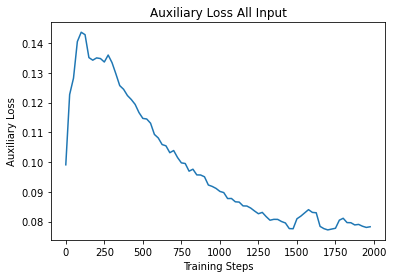

In [9]:
# plotting auxiliary loss
plt.figure()
plt.plot(train_steps, losses_aux)
plt.title('Auxiliary Loss All Input')
plt.xlabel("Training Steps")
plt.ylabel("Auxiliary Loss")
plt.show()

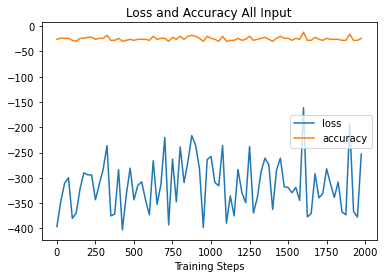

In [10]:
plt.figure()
plt.plot(train_steps, main_loss)
plt.plot(train_steps, accuracy)
plt.title('Loss and Accuracy All Input')
plt.legend(('loss', 'accuracy'))
plt.xlabel("Training Steps")
plt.show()